Obteniendo datos...
Intentando descargar datos para los siguientes tickers: ['BTC-USD', 'MSTR', 'COIN', 'MARA', 'RIOT', 'HIVE', 'SQ', 'PYPL', 'ARBK']


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


✓ BTC-USD: 1096 días de datos disponibles
✓ MSTR: 753 días de datos disponibles
✓ COIN: 753 días de datos disponibles


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


✓ MARA: 753 días de datos disponibles
✓ RIOT: 753 días de datos disponibles
✓ HIVE: 753 días de datos disponibles


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


✓ SQ: 753 días de datos disponibles
✓ PYPL: 753 días de datos disponibles


[*********************100%***********************]  1 of 1 completed


✓ ARBK: 753 días de datos disponibles

Período de datos: 2021-11-05 00:00:00+00:00 hasta 2024-11-04 00:00:00+00:00
Número de días de trading: 753

Acciones incluidas en el análisis: ['BTC-USD', 'MSTR', 'COIN', 'MARA', 'RIOT', 'HIVE', 'SQ', 'PYPL', 'ARBK']

Correlaciones con BTC-USD:
BTC-USD    1.000000
MSTR       0.908727
COIN       0.895382
MARA       0.587660
RIOT       0.368217
SQ         0.265822
HIVE       0.200674
ARBK       0.118410
PYPL       0.081195
Name: BTC-USD, dtype: float64

Generando visualizaciones de datos...


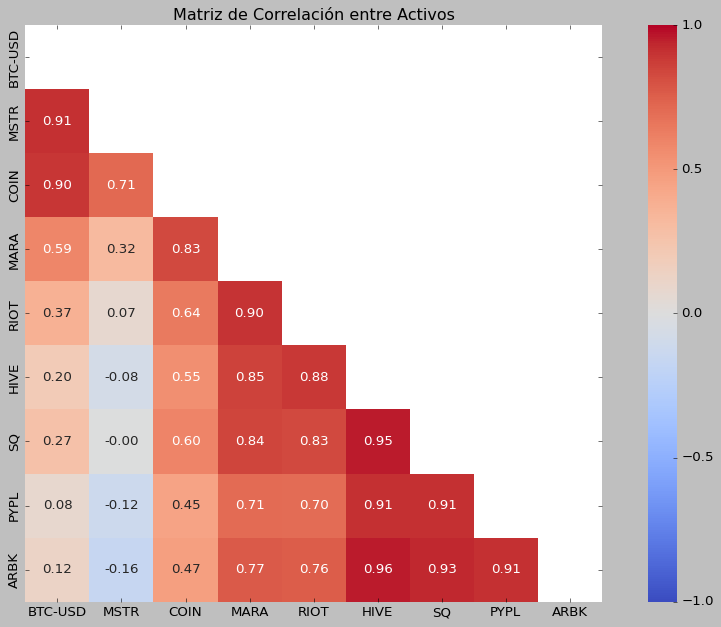

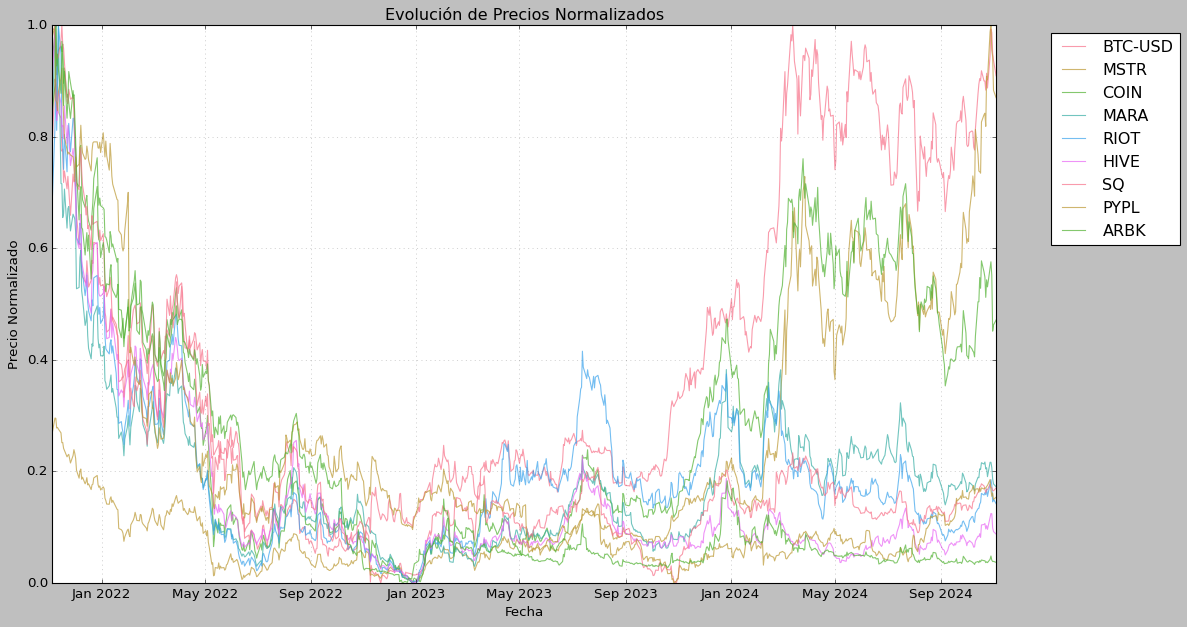

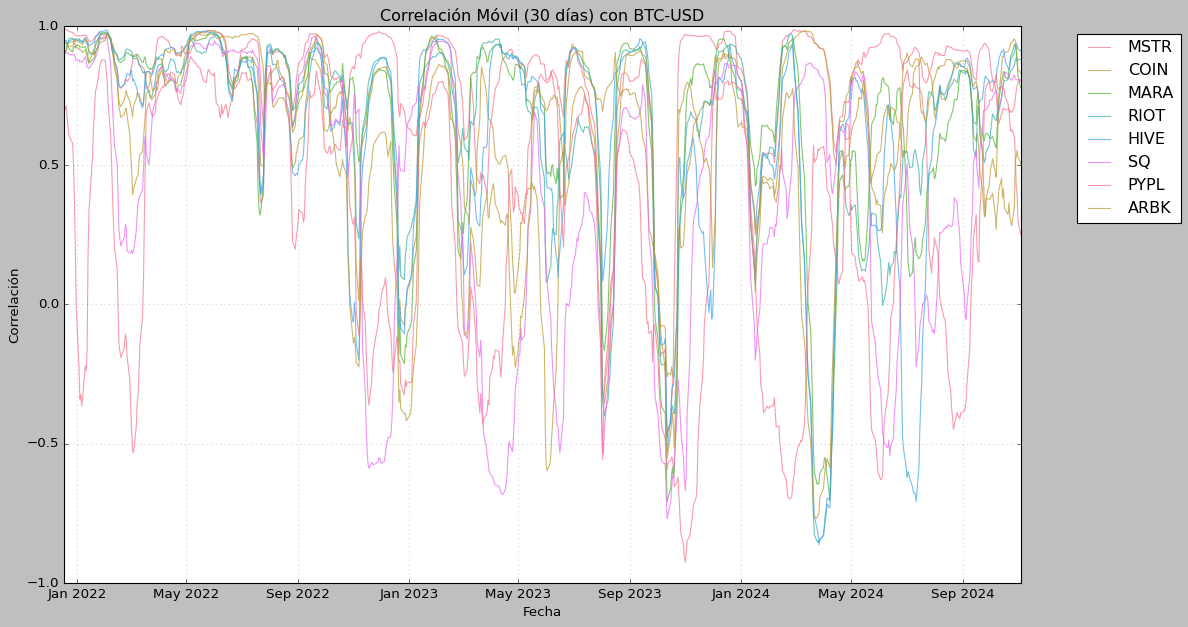


Preparando datos...

Entrenando modelos...

Analizando coeficientes...

Resultados del modelo:

Ridge:
MSE: 0.0314
R2 Score: 0.9699
CV Scores - Mean: -2.0238, Std: 3.8271

Lasso:
MSE: 0.0764
R2 Score: 0.9267
CV Scores - Mean: -7.1144, Std: 9.4862

ElasticNet:
MSE: 0.0639
R2 Score: 0.9387
CV Scores - Mean: -3.7075, Std: 6.0017

Importancia relativa de cada acción (%):
      Ridge_pct  Lasso_pct  ElasticNet_pct
MSTR      23.40      52.29           51.84
COIN      26.32      47.71           48.16
MARA       0.28       0.00            0.00
RIOT       7.14       0.00            0.00
HIVE      13.29       0.00            0.00
SQ         4.31       0.00            0.00
PYPL      12.90       0.00            0.00
ARBK      12.36       0.00            0.00

Generando visualizaciones de resultados...


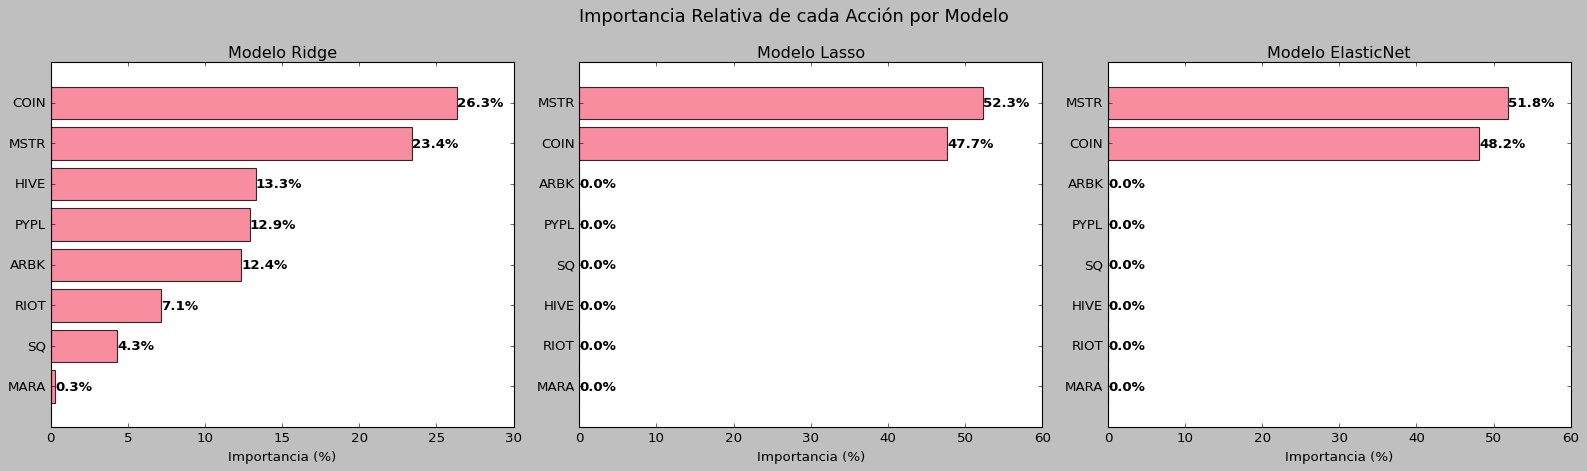

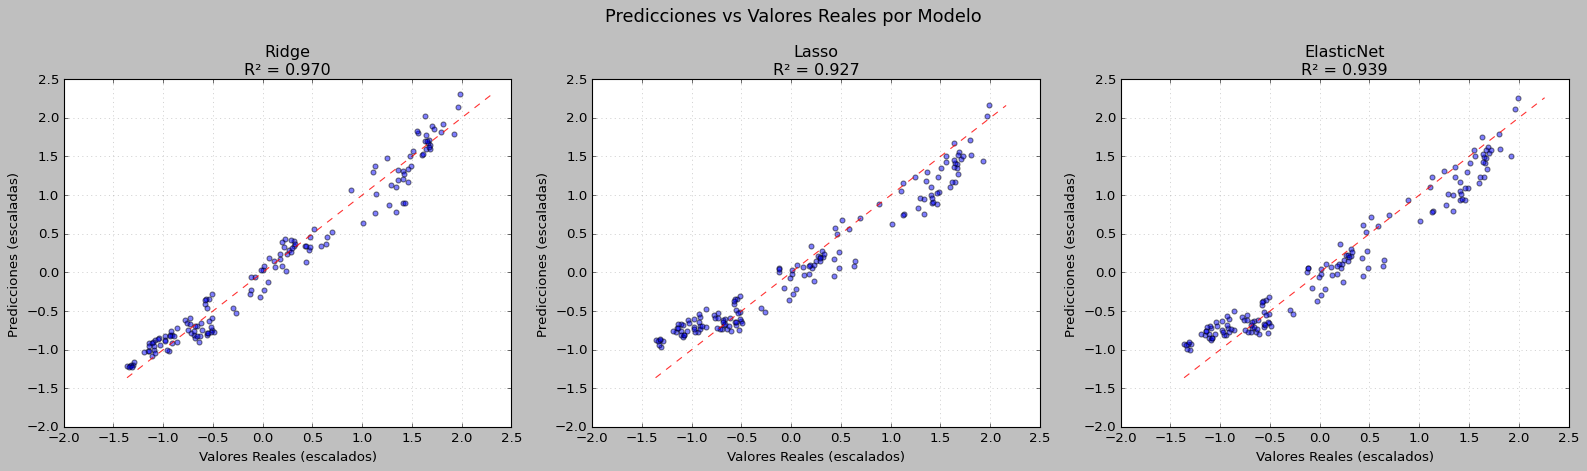

In [ ]:
import pandas as pd
import numpy as np
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
import yfinance as yf
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error, r2_score

def set_style():
    # Configurar el estilo de las visualizaciones
    plt.style.use('classic')
    sns.set_palette("husl")
    plt.rcParams['figure.figsize'] = [12, 7]
    plt.rcParams['font.size'] = 12

def plot_correlation_heatmap(df):
    plt.figure(figsize=(12, 8))
    correlation_matrix = df.corr()

    # Crear máscara para el triángulo superior
    mask = np.zeros_like(correlation_matrix)
    mask[np.triu_indices_from(mask)] = True

    # Crear heatmap
    sns.heatmap(correlation_matrix,
                mask=mask,
                annot=True,
                fmt='.2f',
                cmap='coolwarm',
                center=0,
                vmin=-1,
                vmax=1,
                square=True)

    plt.title('Matriz de Correlación entre Activos')
    plt.tight_layout()
    plt.show()

def plot_normalized_prices(df):
    # Normalizar precios al rango [0,1] para mejor comparación
    normalized_df = (df - df.min()) / (df.max() - df.min())

    plt.figure(figsize=(15, 8))
    for column in normalized_df.columns:
        plt.plot(normalized_df.index, normalized_df[column], label=column, alpha=0.7)

    plt.title('Evolución de Precios Normalizados')
    plt.xlabel('Fecha')
    plt.ylabel('Precio Normalizado')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

def plot_importance_comparison(coef_df):
    # Obtener solo las columnas de porcentajes
    pct_cols = [col for col in coef_df.columns if 'pct' in col]
    importance_df = coef_df[pct_cols]

    # Crear figura con subplots para cada modelo
    fig, axes = plt.subplots(1, 3, figsize=(20, 6))
    fig.suptitle('Importancia Relativa de cada Acción por Modelo', fontsize=16)

    for i, col in enumerate(pct_cols):
        model_name = col.replace('_pct', '')

        # Ordenar valores por importancia
        sorted_importance = importance_df[col].sort_values(ascending=True)

        # Crear barras horizontales
        bars = axes[i].barh(range(len(sorted_importance)),
                          sorted_importance,
                          alpha=0.8)

        # Añadir etiquetas
        axes[i].set_yticks(range(len(sorted_importance)))
        axes[i].set_yticklabels(sorted_importance.index)
        axes[i].set_title(f'Modelo {model_name}')
        axes[i].set_xlabel('Importancia (%)')

        # Añadir valores en las barras
        for bar in bars:
            width = bar.get_width()
            axes[i].text(width,
                        bar.get_y() + bar.get_height()/2,
                        f'{width:.1f}%',
                        ha='left',
                        va='center',
                        fontweight='bold')

    plt.tight_layout()
    plt.show()

def plot_predictions_vs_actual(results):
    fig, axes = plt.subplots(1, 3, figsize=(20, 6))
    fig.suptitle('Predicciones vs Valores Reales por Modelo', fontsize=16)

    for i, (name, metrics) in enumerate(results.items()):
        y_test = metrics['test_actual']
        y_pred = metrics['test_predictions']

        # Crear scatter plot
        axes[i].scatter(y_test, y_pred, alpha=0.5)

        # Añadir línea de referencia perfecta
        min_val = min(y_test.min(), y_pred.min())
        max_val = max(y_test.max(), y_pred.max())
        axes[i].plot([min_val, max_val], [min_val, max_val], 'r--', alpha=0.8)

        axes[i].set_title(f'{name}\nR² = {metrics["r2"]:.3f}')
        axes[i].set_xlabel('Valores Reales (escalados)')
        axes[i].set_ylabel('Predicciones (escaladas)')
        axes[i].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

def calculate_rolling_correlation(df, window=30):
    # Calcular correlaciones móviles con BTC-USD
    rolling_corr = pd.DataFrame()
    for column in df.columns:
        if column != 'BTC-USD':
            rolling_corr[column] = df['BTC-USD'].rolling(window).corr(df[column])

    # Plotear correlaciones móviles
    plt.figure(figsize=(15, 8))
    for column in rolling_corr.columns:
        plt.plot(rolling_corr.index, rolling_corr[column], label=column, alpha=0.7)

    plt.title(f'Correlación Móvil ({window} días) con BTC-USD')
    plt.xlabel('Fecha')
    plt.ylabel('Correlación')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

def main():
    # Configurar estilo
    set_style()

    # Obtener datos
    print("Obteniendo datos...")
    df = fetch_data()

    # Visualizaciones iniciales
    print("\nGenerando visualizaciones de datos...")
    plot_correlation_heatmap(df)
    plot_normalized_prices(df)
    calculate_rolling_correlation(df)

    # Preparar datos
    print("\nPreparando datos...")
    X_scaled, y_scaled, scaler_X, scaler_y, feature_names = prepare_data(df)

    # Entrenar modelos
    print("\nEntrenando modelos...")
    results, X_train, X_test, y_train, y_test = train_models(X_scaled, y_scaled)

    # Analizar coeficientes
    print("\nAnalizando coeficientes...")
    coef_df = analyze_coefficients(results, feature_names)

    # Mostrar resultados
    print("\nResultados del modelo:")
    for name, metrics in results.items():
        print(f"\n{name}:")
        print(f"MSE: {metrics['mse']:.4f}")
        print(f"R2 Score: {metrics['r2']:.4f}")
        print(f"CV Scores - Mean: {metrics['cv_scores'].mean():.4f}, Std: {metrics['cv_scores'].std():.4f}")

    print("\nImportancia relativa de cada acción (%):")
    importance_cols = [col for col in coef_df.columns if 'pct' in col]
    print(coef_df[importance_cols].round(2))

    # Visualizaciones de resultados
    print("\nGenerando visualizaciones de resultados...")
    plot_importance_comparison(coef_df)
    plot_predictions_vs_actual(results)

if __name__ == "__main__":
    main()